# Facebook Prophet

<a href="https://facebook.github.io/prophet/">Prophet</a> is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

from fbprophet import Prophet

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-wind_speed.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,3.0,4.0,2.0,4.0,7.0,4.0,6.0,2.0,8.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,4.0,5.0,4.0,6.0,3.0,3.0,7.0,4.0,5.0,1.0,3.0,2.0,7.0,1.0,0.0,3.0,4.0,4.0,0.0
2017-03-25 02:00:00,3.0,4.0,3.0,5.0,6.0,1.0,7.0,2.0,5.0,1.0,2.0,4.0,5.0,4.0,4.0,4.0,8.0,3.0,3.0,1.0,3.0,3.0,2.0,6.0,4.0,6.0,2.0,3.0,2.0,6.0,1.0,0.0,5.0,4.0,4.0,0.0
2017-03-25 03:00:00,2.0,3.0,3.0,3.0,5.0,1.0,7.0,3.0,6.0,0.0,2.0,2.0,5.0,2.0,4.0,4.0,2.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,3.0,3.0,2.0,3.0,1.0,5.0,1.0,1.0,3.0,4.0,4.0,1.0
2017-03-25 04:00:00,2.0,3.0,3.0,4.0,2.0,4.0,3.0,1.0,1.0,0.0,2.0,3.0,10.0,2.0,4.0,5.0,5.0,3.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,3.0,2.0,2.0,1.0,5.0,1.0,1.0,6.0,0.0,0.0,1.0
2017-03-25 05:00:00,2.0,2.0,3.0,4.0,5.0,2.0,2.0,1.0,4.0,1.0,2.0,6.0,2.0,3.0,2.0,4.0,7.0,2.0,3.0,2.0,3.0,3.0,2.0,6.0,3.0,2.0,2.0,4.0,1.0,6.0,1.0,1.0,4.0,3.0,3.0,1.0


## Define Parameters

Make predictions for 24-hour period using a training period of four weeks.

In [4]:
dataset_name = 'Hourly Weather Wind Speed'
dataset_abbr = 'HWS'
model_name = 'Prophet'
context_length = 24*7*4 # Four weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example Prophet Models

Exploration of how Prophet works with various implementations.

Prophet requires data in a specific format: a column 'ds' containing the DateTime values of each observation and a target column 'y'.

In [6]:
ts_ex = 10
df_ex = df.reset_index()
df_ex = df_ex.iloc[:, [0, ts_ex]]
df_ex.columns = ['ds', 'y']
print(df_ex.shape)
df_ex.head()

(5000, 2)


,ds,y
0,2017-03-25 01:00:00,3.0
1,2017-03-25 02:00:00,1.0
2,2017-03-25 03:00:00,0.0
3,2017-03-25 04:00:00,0.0
4,2017-03-25 05:00:00,1.0


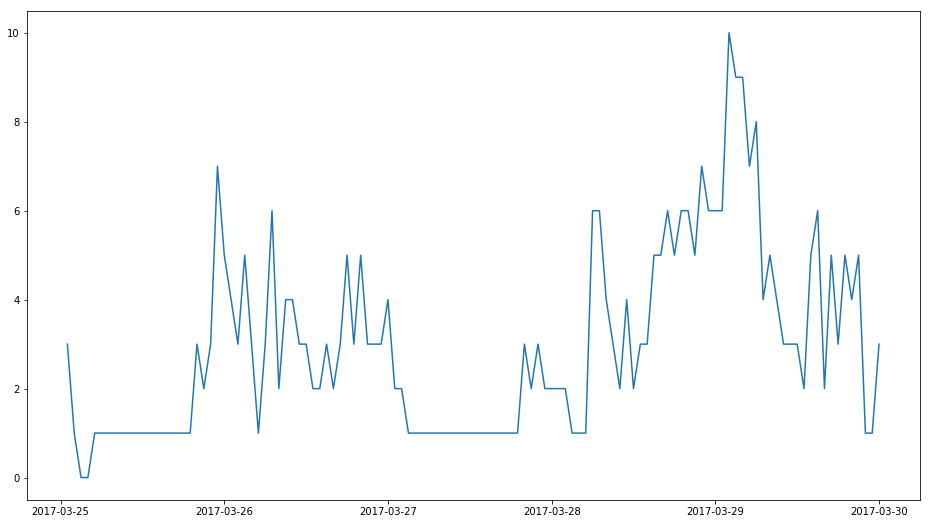

In [7]:
# Plot data from first five days
plt.plot(df_ex['ds'][:120], df_ex['y'][:120]);

In [8]:
import warnings
warnings.filterwarnings('ignore')

### Model 1 - Prophet Default

The first model is a vanilla implementation of Prophet. First, the model is instantiated, before fitting it to the training data.

In [9]:
df_ex = df_ex.iloc[-(prediction_length+context_length):]

In [10]:
m = Prophet()

tic = time()
m.fit(df_ex.iloc[:-prediction_length])
toc = time()

print("Time to fit model: {:.1f}s".format(toc-tic))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Time to fit model: 0.5s


Next, predictions are generated for both the training and test data. The actual target values are added back to the forecast DataFrame, and a column is created to distinguish training from test data.

In [11]:
tic = time()
forecast = m.predict(df_ex)
toc = time()
print("Time to make predictions: {:.1f}s".format(toc-tic))

forecast['y'] = df_ex['y'].values
forecast['training'] = 0
forecast['training'].iloc[:-prediction_length] = 1

Time to make predictions: 2.6s


Prophet has a convenience function for visualising the model's predictions. Here the training data (black points) and the test data (red points) are plotted, along with Prophet's prediction (blue line) and Prophet's 80% confidence interval (light blue area).

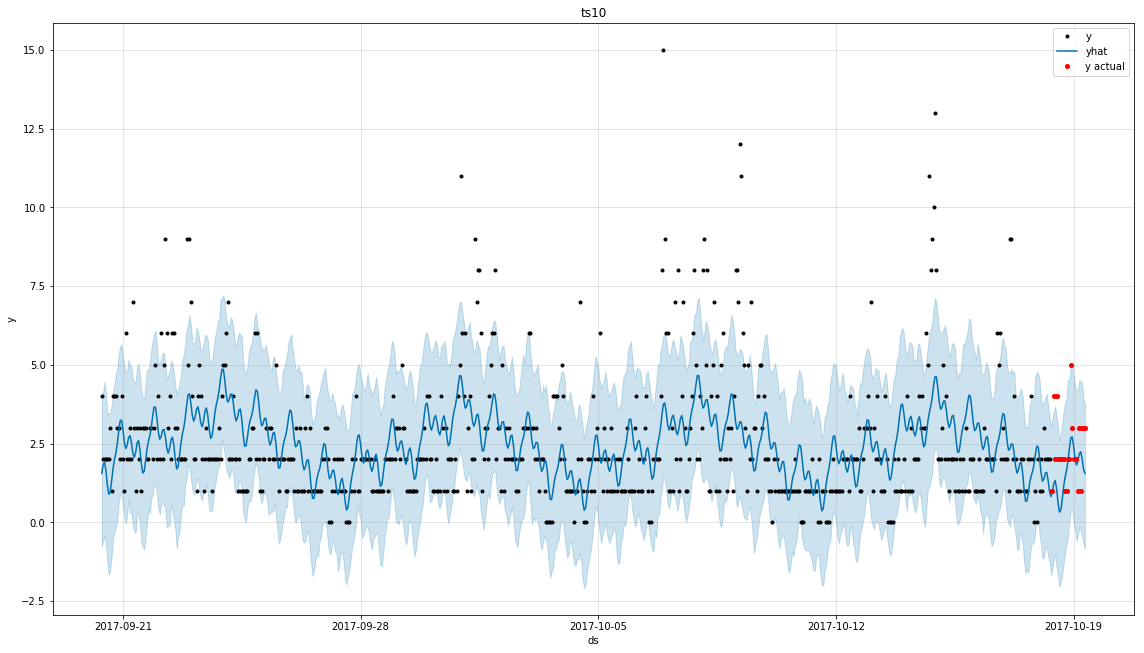

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
m.plot(forecast, ax=ax)
ax.plot_date(forecast.loc[forecast['training'] == 0, 'ds'], forecast.loc[forecast['training'] == 0, 'y'],
             c='r', markersize=4, label='y actual')
ax.set_title('ts%s' % ts_ex)
ax.legend();

### Model 2 - Prophet with a Saturating Minimum

To address any negative values that appear, Prophet can be configured to use a logistic growth model with a saturating minimum (see <a href='https://facebook.github.io/prophet/docs/saturating_forecasts.html'>the official documentation</a>). This requires the datasets to be modified to include minimum and maximum values for the model (Prophet requires the latter to be included even if there isn't a need to cap both limits in reality).

In [13]:
df_ex['cap'] = df_ex['y'].max()*1.1 # Arbitrarily cap the model at 1.1x the highest observed value
df_ex['floor'] = 0

m_sm = Prophet(growth='logistic') # Specify logistic growth model
tic = time()
m_sm.fit(df_ex.iloc[:-prediction_length])
toc = time()
print("Time to fit model: {:.1f}s".format(toc-tic))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Time to fit model: 0.6s


In [14]:
tic = time()
forecast_sm = m_sm.predict(df_ex)
toc = time()
print("Time to make predictions: {:.1f}s".format(toc-tic))

forecast_sm['y'] = df_ex['y'].values
forecast_sm['training'] = 0
forecast_sm['training'].iloc[:-prediction_length] = 1

Time to make predictions: 3.1s


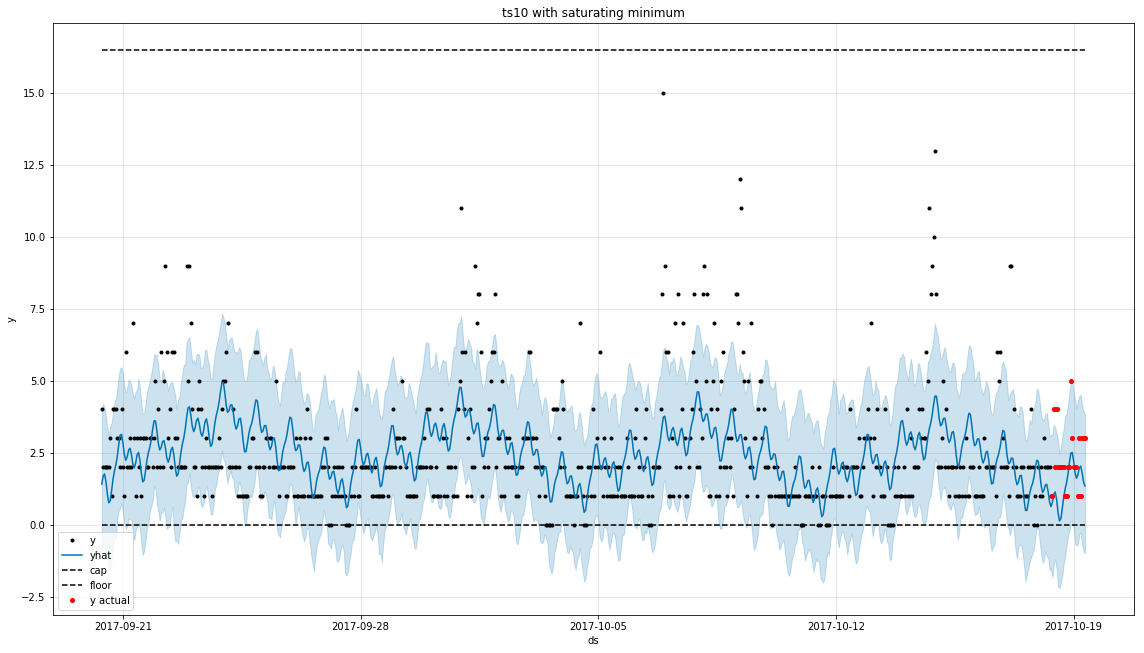

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
m_sm.plot(forecast_sm, ax=ax)
ax.plot_date(forecast_sm.loc[forecast_sm['training'] == 0, 'ds'], forecast_sm.loc[forecast_sm['training'] == 0, 'y'],
             c='r', markersize=4, label='y actual')
ax.set_title('ts%s with saturating minimum' % ts_ex)
ax.legend();

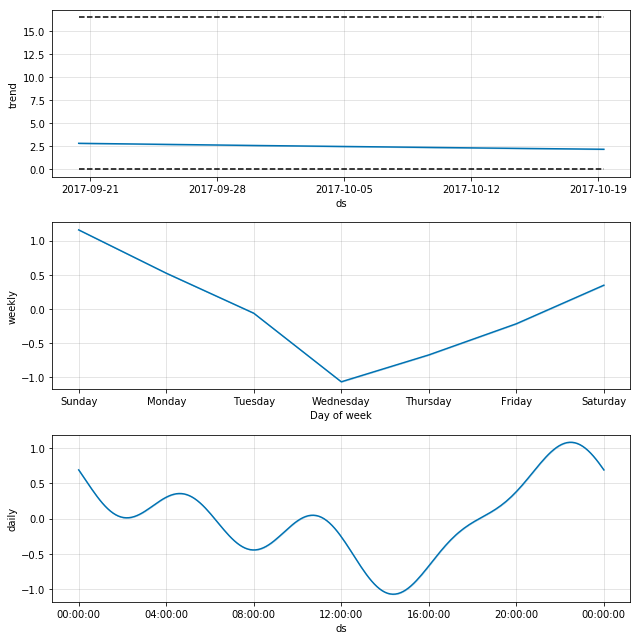

In [16]:
fig = m_sm.plot_components(forecast_sm)

This has not resolved the issue - it appears that the cap and floor only apply to the trend component, and as such, the overall prediction may still fall outside of these values. <a href='https://github.com/facebook/prophet/issues/470'>This GitHub issue</a> suggests that a different approach may be needed to avoid negative values for non-daily data such as this.

### Model 3 - Prophet with Log Transformed Data

The Prophet model can be fitted to the log of the data, and then the predictions can subsequently be converted back to the original form, to ensure only positive values are predicted. `np.log1p(y)` will be used to avoid log(0) errors for y=0, with reconversion being applied using `np.expm1(y_pred)`.

In [17]:
df_log = df.reset_index()
df_log = df_log.iloc[:, [0, ts_ex]]
df_log.columns = ['ds', 'y']
df_log['y'] = np.log1p(df_log['y'])
print(df_log.shape)
df_log.iloc[10:15]

(5000, 2)


,ds,y
10,2017-03-25 11:00:00,0.693147
11,2017-03-25 12:00:00,0.693147
12,2017-03-25 13:00:00,0.693147
13,2017-03-25 14:00:00,0.693147
14,2017-03-25 15:00:00,0.693147


In [18]:
df_log = df_log.iloc[-(prediction_length+context_length):]

In [19]:
m_log = Prophet()

tic = time()
m_log.fit(df_log.iloc[:-prediction_length])
toc = time()

print("Time to fit model: {:.1f}s".format(toc-tic))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Time to fit model: 0.2s


In [20]:
tic = time()
forecast_log = m_log.predict(df_log)
toc = time()
print("Time to make predictions: {:.1f}s".format(toc-tic))

forecast_log['y'] = df_log['y'].values
forecast_log['training'] = 0
forecast_log['training'].iloc[:-prediction_length] = 1

Time to make predictions: 2.6s


In [21]:
for col in forecast_log.columns[1:-1]:
    forecast_log[col] = np.expm1(forecast_log[col])

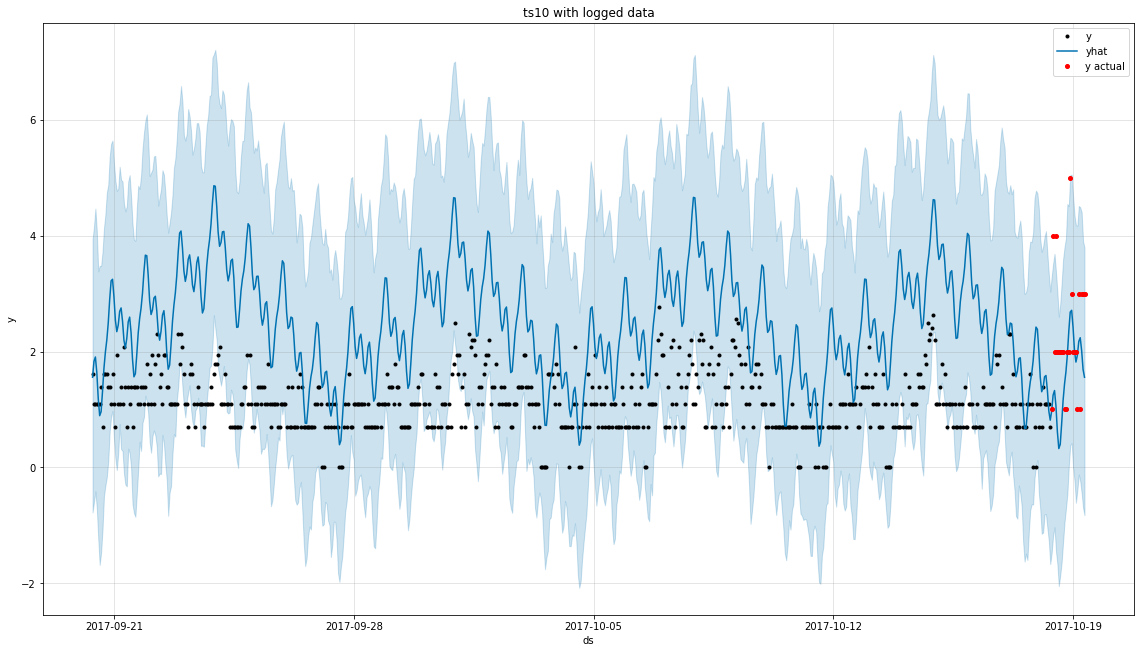

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
m_log.plot(forecast, ax=ax)
ax.plot_date(forecast_log.loc[forecast_log['training'] == 0, 'ds'], forecast_log.loc[forecast_log['training'] == 0, 'y'],
             c='r', markersize=4, label='y actual')
ax.set_title('ts%s with logged data' % ts_ex)
ax.legend();
# The model retains the logged values of the training data points,
# so black scatter points do not represent the true values

Some of the predictions still look to be slightly below zero. Visually comparing the logged model with the previous two, it also seems to underestimate the peaks.

### Comparison of Models

Examine the mean absolute errors (MAEs) for the three models.

In [23]:
print("Original model MAE: {:.4f}".format(
      np.mean(np.abs(forecast.loc[forecast['training'] == 0, 'y']-forecast.loc[forecast['training'] == 0, 'yhat']))))
print("Saturated minimum model MAE: {:.4f}".format(
      np.mean(np.abs(forecast_sm.loc[forecast_sm['training'] == 0, 'y']-forecast_sm.loc[forecast_sm['training'] == 0, 'yhat']))))
print("Logged model MAE: {:.4f}".format(
      np.mean(np.abs(forecast_log.loc[forecast_log['training'] == 0, 'y']-forecast_log.loc[forecast_log['training'] == 0, 'yhat']))))

Original model MAE: 1.0243
Saturated minimum model MAE: 1.1226
Logged model MAE: 1.0984


The logged model appears to perform best, however, this is likely due to the larger errors for the negative values in the two other models. For all three sets of predictions, the negative values can be changed to zero.

In [24]:
forecasts = [forecast.iloc[:, 1:].copy(), forecast_sm.iloc[:, 1:].copy(), forecast_log.iloc[:, 1:].copy()]
for fcst in forecasts:
    fcst[fcst < 0] = 0
    fcst['ds'] = forecast['ds']

In [25]:
print("Original model (zeroed) MAE: {:.4f}".format(
      np.mean(np.abs(forecasts[0].loc[forecasts[0]['training'] == 0, 'y']-forecasts[0].loc[forecasts[0]['training'] == 0, 'yhat']))))
print("Saturated minimum model (zeroed) MAE: {:.4f}".format(
      np.mean(np.abs(forecasts[1].loc[forecasts[1]['training'] == 0, 'y']-forecasts[1].loc[forecasts[1]['training'] == 0, 'yhat']))))
print("Logged model (zeroed) MAE: {:.4f}".format(
      np.mean(np.abs(forecasts[2].loc[forecasts[2]['training'] == 0, 'y']-forecasts[2].loc[forecasts[2]['training'] == 0, 'yhat']))))

Original model (zeroed) MAE: 1.0243
Saturated minimum model (zeroed) MAE: 1.1226
Logged model (zeroed) MAE: 1.0984


The models now have very similar performance. For simplicity, the original model will be used with subsequent zeroing of any negative values.

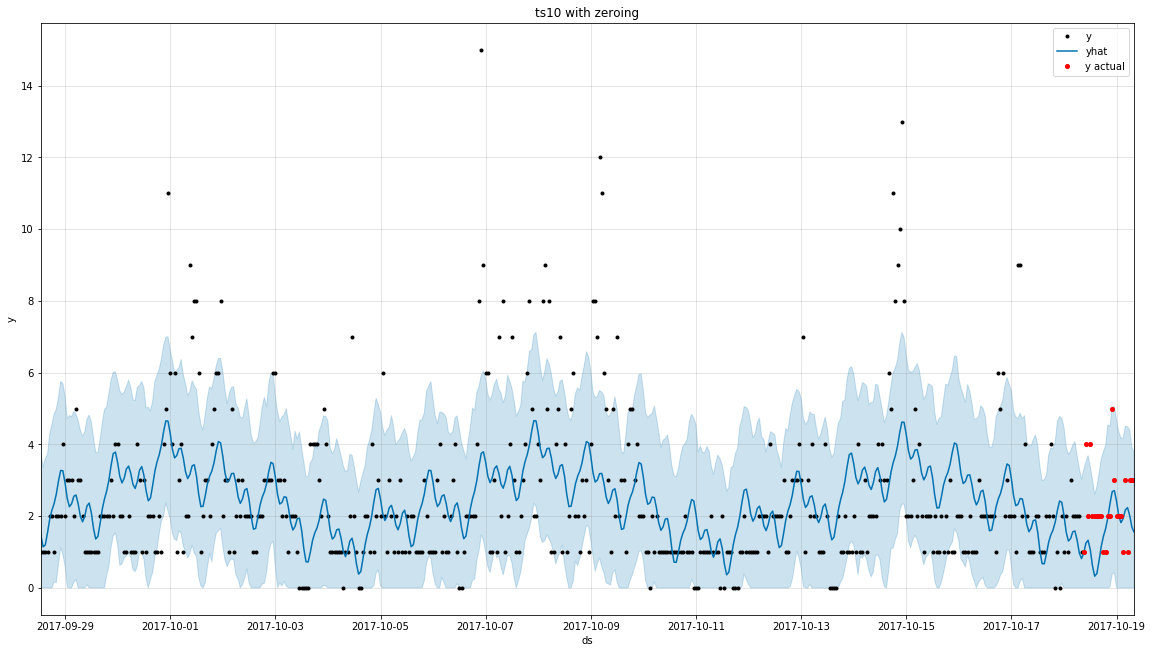

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))
m.plot(forecasts[0], ax=ax)
ax.plot_date(forecasts[0].loc[forecasts[0]['training'] == 0, 'ds'], forecasts[0].loc[forecasts[0]['training'] == 0, 'y'],
             c='r', markersize=4, label='y actual')
ax.set_title('ts%s with zeroing' % ts_ex)
ax.legend()
ax.set_xlim(forecasts[0]['ds'].iloc[-500], forecasts[0]['ds'].iloc[-1]);

## Evaluating Prophet

To evaluate Prophet, forecasts will be generated for each time series using the original model (with subsequent zeroing of the negative values). sMASE will be calculated for each individual time series, and the mean of all these scores will be used as the overall accuracy metric for Prophet on this dataset.

In [27]:
results = df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for column {}. Cumulative time {:.2f}s.".format(col, toc-tic))
        
    # Prepare DataFrame for selected column
    dft = df.reset_index()
    dft = dft.iloc[-(prediction_length+context_length):]
    dft = dft.iloc[:, [0, int(col[2:])]]
    dft.columns = ['ds', 'y']

    # Fit model and make predictions
    m = Prophet()
    m.fit(dft.iloc[:-prediction_length])
    fcst = m.predict(dft)
    
    # Store results
    results['pred%s' % col[2:]] = fcst['yhat'].values

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Running predictions for column ts1. Cumulative time 0.00s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column ts11. Cumulative time 28.74s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column ts21. Cumulative time 58.44s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

Running predictions for column ts31. Cumulative time 91.74s.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predictions must be greater than 0 and the actual values are always integers.

In [28]:
results0 = results.copy()
results0[results0 < 0] = 0
results0 = results0.apply(round)
results0.tail()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-19 04:00:00,7.0,5.0,2.0,7.0,0.0,1.0,1.0,2.0,4.0,3.0,3.0,4.0,2.0,4.0,2.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,4.0,3.0,2.0,1.0,3.0,1.0,1.0,3.0,5.0,5.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,3.0,3.0,1.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,2.0,4.0,2.0,2.0,2.0,3.0,6.0,4.0,3.0,5.0,4.0,1.0,1.0,5.0,2.0,2.0,1.0
2017-10-19 05:00:00,2.0,5.0,2.0,4.0,0.0,1.0,1.0,2.0,3.0,1.0,3.0,5.0,4.0,5.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,4.0,3.0,3.0,2.0,3.0,1.0,0.0,5.0,5.0,5.0,0.0,3.0,2.0,2.0,2.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,3.0,6.0,4.0,3.0,5.0,4.0,1.0,1.0,5.0,2.0,2.0,1.0
2017-10-19 06:00:00,3.0,7.0,2.0,5.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,5.0,4.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,4.0,8.0,2.0,2.0,3.0,2.0,3.0,2.0,5.0,1.0,1.0,0.0,3.0,4.0,4.0,0.0,3.0,2.0,2.0,2.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,3.0,6.0,4.0,3.0,5.0,4.0,1.0,1.0,5.0,2.0,2.0,1.0
2017-10-19 07:00:00,5.0,5.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,5.0,3.0,1.0,3.0,2.0,2.0,2.0,4.0,2.0,5.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,5.0,3.0,1.0,1.0,3.0,5.0,5.0,0.0,3.0,2.0,1.0,2.0,0.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,3.0,6.0,5.0,3.0,5.0,4.0,2.0,1.0,6.0,2.0,2.0,1.0
2017-10-19 08:00:00,1.0,7.0,3.0,3.0,0.0,1.0,1.0,2.0,4.0,3.0,1.0,4.0,2.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0,0.0,1.0,3.0,4.0,2.0,2.0,6.0,3.0,1.0,1.0,1.0,4.0,4.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,3.0,6.0,5.0,3.0,5.0,3.0,2.0,2.0,6.0,3.0,3.0,2.0


In [29]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

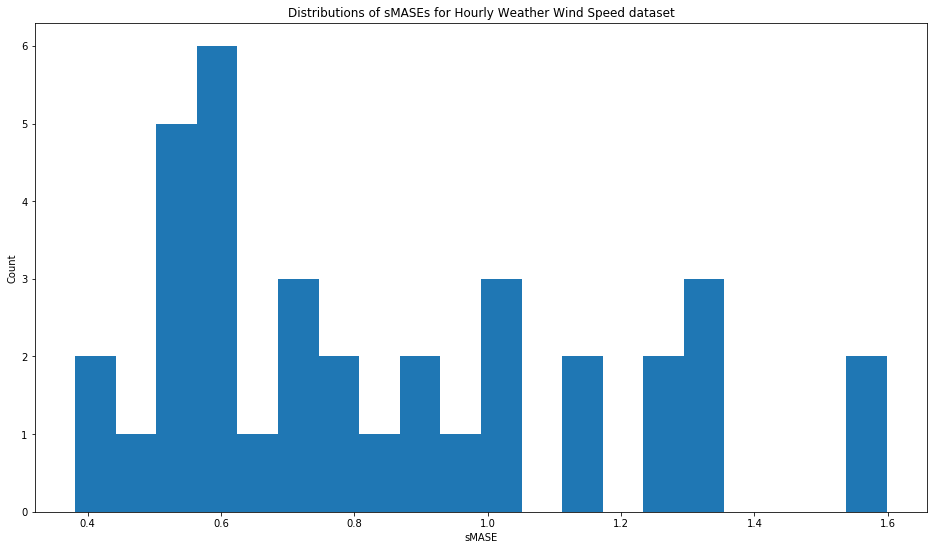

In [30]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [31]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.8493


Show some example forecasts.

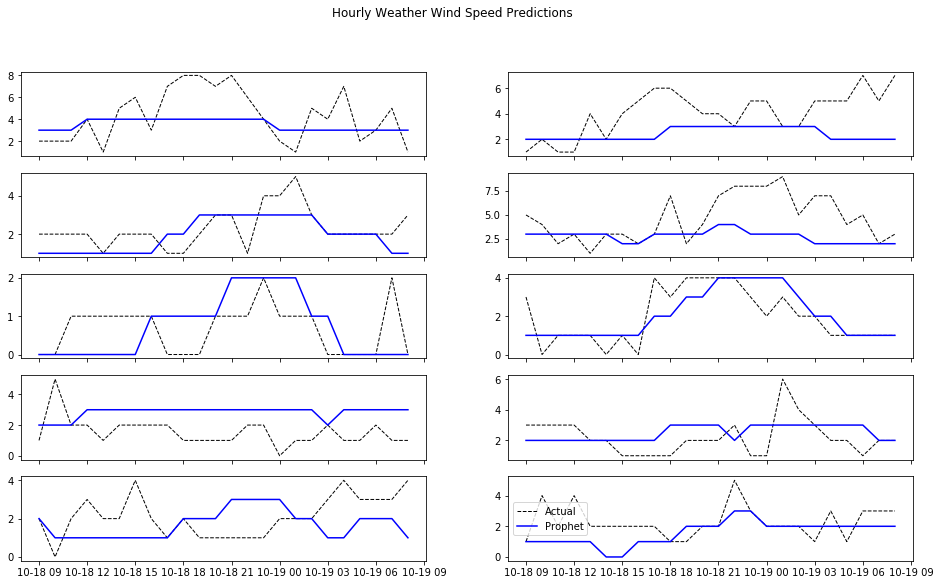

In [32]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results0.index[-prediction_length:], results0['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results0.index[-prediction_length:], results0['pred%s' % col].iloc[-prediction_length:],
                   label='Prophet', c='b')
ax[9].legend()
fig.suptitle('{} Predictions'.format(dataset_name));

Store the predictions and accuracy score for the Prophet models.

In [33]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)